# SandBox for MNIST Dataset

## Overview:

Due to initial hiccups with training for Chest XRay Dataset, we'll do a sanity check on the model using MNIST.
Notebook inspired by this one: https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=mMAC98JRb41t

Note that in their case they used a binary crossentropy loss as opposed to a gaussian loss.

## Data Source


### Publication

https://arxiv.org/abs/1705.02315

### URL

https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import VAE
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from matplotlib import pyplot as plt
from matplotlib import cm
from warnings import warn
import os
import re
import datetime
from tqdm import tqdm
import gc
import torch.nn.functional as F

In [2]:
# run options
torch.manual_seed(42)
num_epochs = 10
batch_size = 1000
learning_rate = 1e-3
use_GPU = True
if not torch.cuda.is_available():
    warn('torch.cuda.is_available() returned False, using CPU')
else:
    print('using GPU')

device = torch.device("cuda:0" if use_GPU and torch.cuda.is_available() else "cpu")

using GPU


In [3]:
# top_dir = '/home/owhitley/projects/chest_xray_8'
top_dir = 'D:\\projects\\chest_XRay_8'
# mean and std deviation manually found on random batch of 1000 samples
# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(0.1314, 0.3090)
# ])
# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(0.5, 0.3090)
# ])
img_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = MNIST(root=os.path.join(top_dir, 'data\\MNIST'), download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MNIST(root=os.path.join(top_dir, 'data\\MNIST'), download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [4]:
# vae_model = VAE.VariationalAutoEncoder(input_size = 28, n_conv = 2, fc0_dims = 32, latent_dims = 16, c = 8, use_batch_norm=True)
vae_model = VAE.VariationalAutoEncoder(input_size = 28, n_conv = 2, latent_dims = 16, c = 8, use_batch_norm=True, output="Sigmoid")
vae_model.to(device)

VariationalAutoEncoder(
  (encoder): Encoder(
    (conv_layers): ModuleList(
      (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (norm_layers): ModuleList(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_mu): Linear(in_features=784, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=784, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (tconv_layers): ModuleList(
      (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (bnorm_layers): ModuleList(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc1): Linear(in_features=16, out_features=784, b

# Train Model

In [5]:
optimizer = torch.optim.Adam(params=vae_model.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae_model.set_train_status(True)

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        x = image_batch.to(device)

        # vae reconstruction
        recon_x, z, mu, logvar = vae_model.forward(x)
        
        # reconstruction error
        loss, _, _ = VAE.vae_loss(recon_x, x, mu, logvar)
        # print('Batch loss:{}'.format(loss.item()))
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] Loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    gc.collect()

Training ...
Epoch [1 / 10] Loss: 158211.647135
Epoch [2 / 10] Loss: 89151.720964
Epoch [3 / 10] Loss: 60571.745052
Epoch [4 / 10] Loss: 51615.402344
Epoch [5 / 10] Loss: 48215.249805
Epoch [6 / 10] Loss: 46380.348893
Epoch [7 / 10] Loss: 45204.474805
Epoch [8 / 10] Loss: 44325.631641
Epoch [9 / 10] Loss: 43582.938086
Epoch [10 / 10] Loss: 42965.737305


In [6]:
x.shape

torch.Size([1000, 1, 28, 28])

In [7]:
recon_x.shape

torch.Size([1000, 1, 28, 28])

In [8]:
vae_model.decoder

Decoder(
  (tconv_layers): ModuleList(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (bnorm_layers): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=16, out_features=784, bias=True)
  (fc1_bn): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

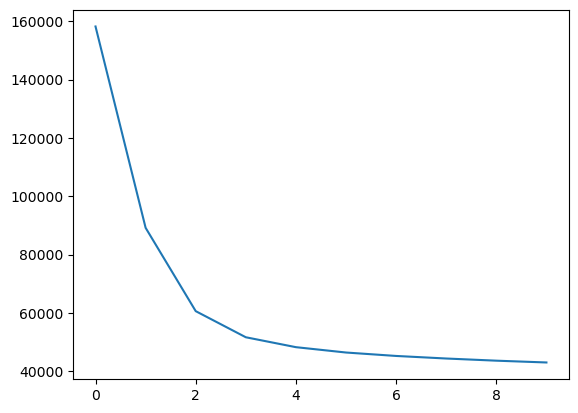

In [9]:
# training loss
plt.plot(train_loss_avg)

Original images


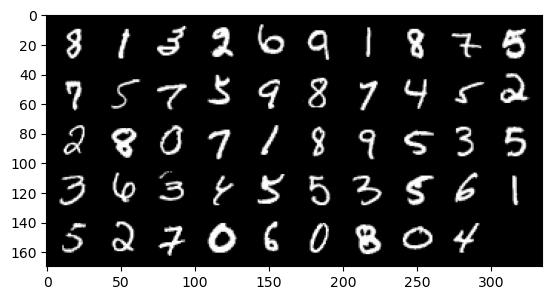

VAE reconstruction:


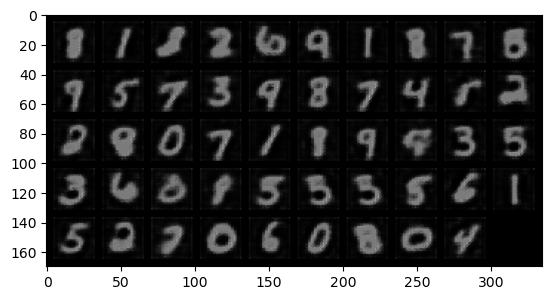

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae_model.set_train_status(False)

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = to_img(images)
        images, _, _, _ = model.forward(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).cpu().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_model)

/tmp/ipykernel_13460/3062256764.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vae_model.forward(images.to(device))[0].to('cpu').detach().numpy())


<Axes: ylabel='Density'>

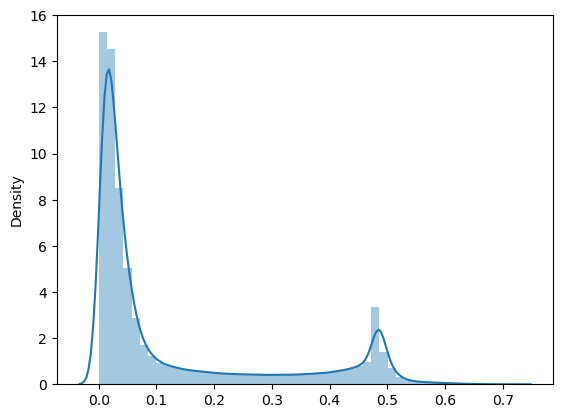

In [11]:
# check that model does not ReLU the output layer
sns.distplot(vae_model.forward(images.to(device))[0].to('cpu').detach().numpy())

/tmp/ipykernel_13460/2793834240.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(recon_x.to('cpu').detach().numpy())


<Axes: ylabel='Density'>

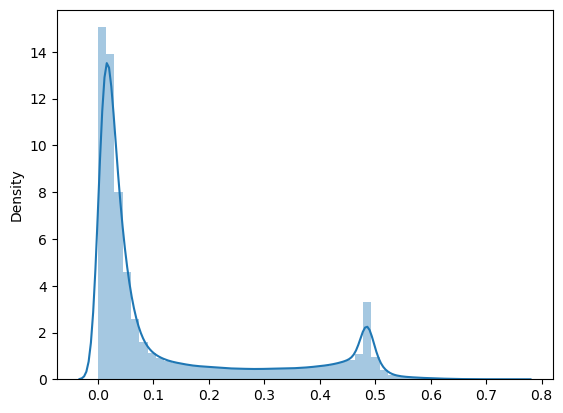

In [12]:
sns.distplot(recon_x.to('cpu').detach().numpy())

/tmp/ipykernel_13460/2565370628.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x.to('cpu').detach().numpy())


<Axes: ylabel='Density'>

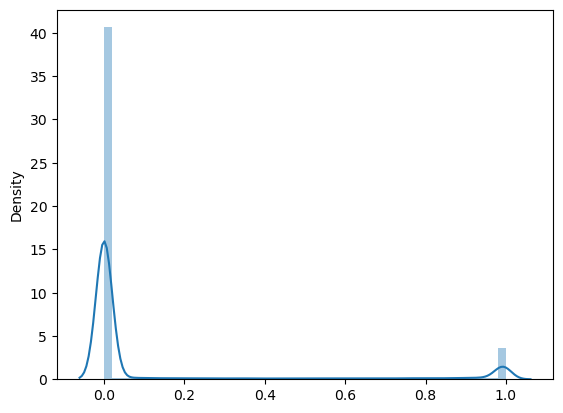

In [13]:
sns.distplot(x.to('cpu').detach().numpy())